# Laboratorio 4
## Clasificación de tweets usando minería de texto
### Integrantes:
### Pablo Escobar - 20936
### Eduardo Ramirez - 19946

In [83]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

In [84]:
train_file = "./data/train.csv"

# read file
train_data = pd.read_csv(train_file)

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Limpieza de datos

In [85]:
# remove caracters like @, ", '
caracters = ['@', '"', "'",'#','&','?','-']

for caracter in caracters:
    train_data['text'] = train_data['text'].str.replace(caracter, '')
    train_data['keyword'] = train_data['keyword'].str.replace(caracter, '')
    train_data['location'] = train_data['location'].str.replace(caracter, '')



In [86]:
# remove urls from text
import re
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

train_data['text'] = train_data['text'].apply(lambda x : remove_urls(x))




In [87]:
# get columns of type string
stringColumns = list(train_data.select_dtypes(include=['object']).columns)
print(stringColumns)

subfix = "_lowercase"
for column in stringColumns:
    train_data[column + subfix] = train_data[column].str.lower()



['keyword', 'location', 'text']


In [88]:
# remove stopwords

nltk.download('stopwords')
stop = stopwords.words('english')

train_data['text_lowercase'] = train_data['text_lowercase'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
# change nan to empty and add a column saying if the value was nan
for column in stringColumns:
    train_data[column + "_nan"] = train_data[column].isna()
    train_data[column] = train_data[column].fillna('empty')

train_data.head()

,id,keyword,location,text,target,keyword_lowercase,location_lowercase,text_lowercase,keyword_nan,location_nan,text_nan
0,1,empty,empty,Our Deeds are the Reason of this earthquake Ma...,1,NaN,NaN,deeds reason earthquake may allah forgive us,True,True,False
1,4,empty,empty,Forest fire near La Ronge Sask. Canada,1,NaN,NaN,forest fire near la ronge sask. canada,True,True,False
2,5,empty,empty,All residents asked to shelter in place are be...,1,NaN,NaN,residents asked shelter place notified officer...,True,True,False
3,6,empty,empty,"13,000 people receive wildfires evacuation ord...",1,NaN,NaN,"13,000 people receive wildfires evacuation ord...",True,True,False
4,7,empty,empty,Just got sent this photo from Ruby Alaska as s...,1,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,True,True,False


In [90]:
# get the rows which target is 1
targetTrue = train_data[train_data['target'] == 1]
targetTrue.head()

# get the rows which target is 0
targetFalse = train_data[train_data['target'] == 0]
targetFalse.head()

,id,keyword,location,text,target,keyword_lowercase,location_lowercase,text_lowercase,keyword_nan,location_nan,text_nan
15,23,empty,empty,Whats up man,0,NaN,NaN,whats man,True,True,False
16,24,empty,empty,I love fruits,0,NaN,NaN,love fruits,True,True,False
17,25,empty,empty,Summer is lovely,0,NaN,NaN,summer lovely,True,True,False
18,26,empty,empty,My car is so fast,0,NaN,NaN,car fast,True,True,False
19,28,empty,empty,What a goooooooaaaaaal!!!!!!,0,NaN,NaN,goooooooaaaaaal!!!!!!,True,True,False


<Axes: >

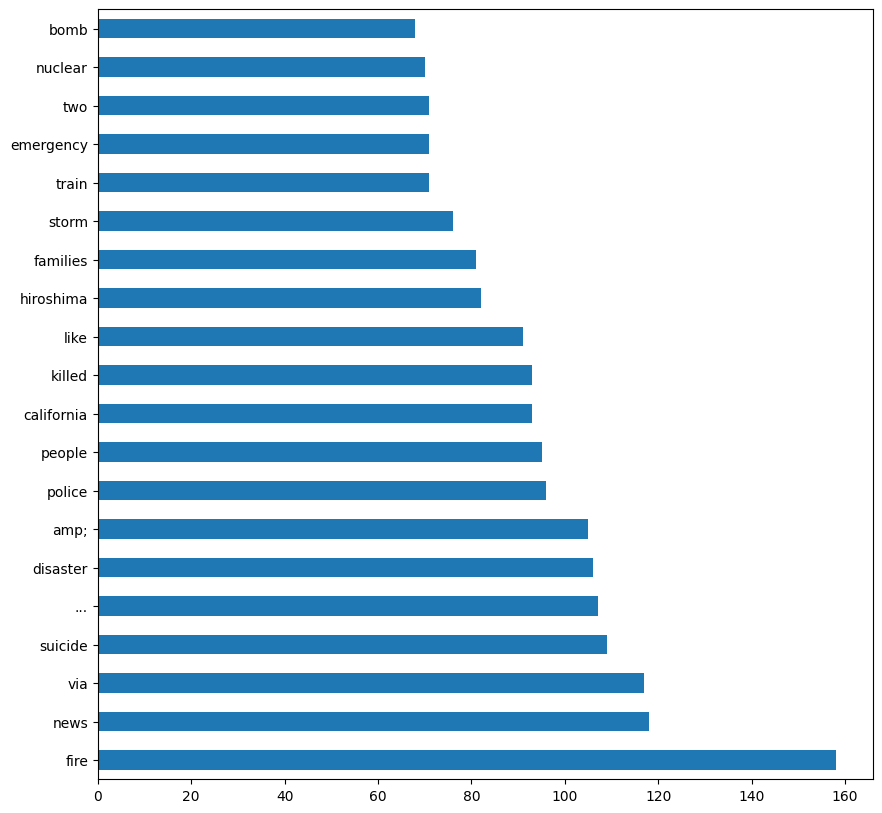

In [91]:
# get the frequency of each word in targetTrue
from collections import Counter
targetTrueWords = targetTrue['text_lowercase'].str.split(expand=True).stack().value_counts()

# plto the 20 most frequent words
targetTrueWords[:20].plot(kind='barh', figsize=(10, 10))



<Axes: >

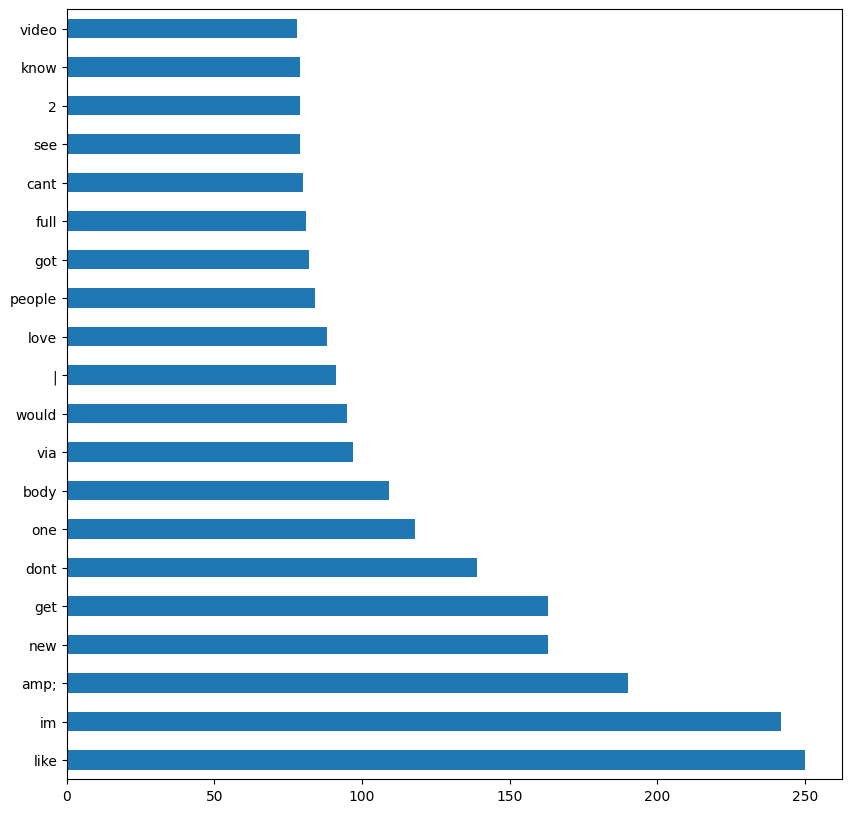

In [92]:
targetFalseWords = targetFalse['text_lowercase'].str.split(expand=True).stack().value_counts()

# plto the 20 most frequent words
targetFalseWords[:20].plot(kind='barh', figsize=(10, 10))

### ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar bigramas o trigramas para analizar contexto?

In [93]:
from nltk import word_tokenize
from nltk.util import ngrams

# bigrams
bigrams = ngrams(targetTrue['text_lowercase'].str.split(expand=True).stack(), 2)
countA =Counter(bigrams).most_common(20)
print(countA)

# trigrams
trigrams = ngrams(targetTrue['text_lowercase'].str.split(expand=True).stack(), 3)
countB =Counter(trigrams).most_common(20)
print(countB)

falseBigrams = ngrams(targetFalse['text_lowercase'].str.split(expand=True).stack(), 2)
countC =Counter(falseBigrams).most_common(20)
print(countC)

falseTrigrams = ngrams(targetFalse['text_lowercase'].str.split(expand=True).stack(), 3)
countD =Counter(falseTrigrams).most_common(20)
print(countD)


[(('suicide', 'bomber'), 59), (('northern', 'california'), 40), (('oil', 'spill'), 37), (('suicide', 'bombing'), 34), (('california', 'wildfire'), 33), (('burning', 'buildings'), 33), (('70', 'years'), 30), (('bomber', 'detonated'), 30), (('homes', 'razed'), 29), (('latest:', 'homes'), 28), (('razed', 'northern'), 28), (('16yr', 'old'), 28), (('pkk', 'suicide'), 28), (('detonated', 'bomb'), 28), (('severe', 'thunderstorm'), 27), (('old', 'pkk'), 27), (('debris', 'found'), 26), (('families', 'sue'), 26), (('40', 'families'), 26), (('families', 'affected'), 26)]
[(('suicide', 'bomber', 'detonated'), 30), (('northern', 'california', 'wildfire'), 28), (('latest:', 'homes', 'razed'), 28), (('homes', 'razed', 'northern'), 28), (('pkk', 'suicide', 'bomber'), 28), (('bomber', 'detonated', 'bomb'), 28), (('razed', 'northern', 'california'), 27), (('16yr', 'old', 'pkk'), 27), (('old', 'pkk', 'suicide'), 27), (('40', 'families', 'affected'), 26), (('families', 'affected', 'fatal'), 26), (('affect

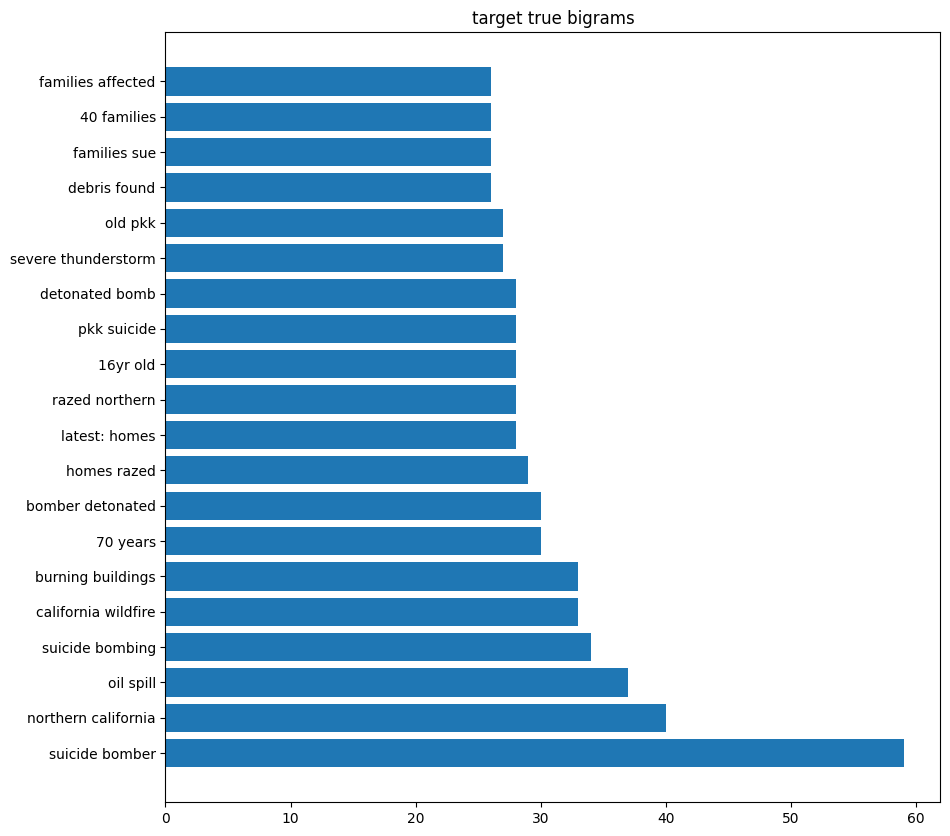

In [94]:
#  target true bigrams
x = [i[0] for i in countA]
x = [' '.join(i) for i in x]
y = [i[1] for i in countA]

plt.figure(figsize=(10, 10))
plt.barh(x, y)
plt.title('target true bigrams')
plt.show()


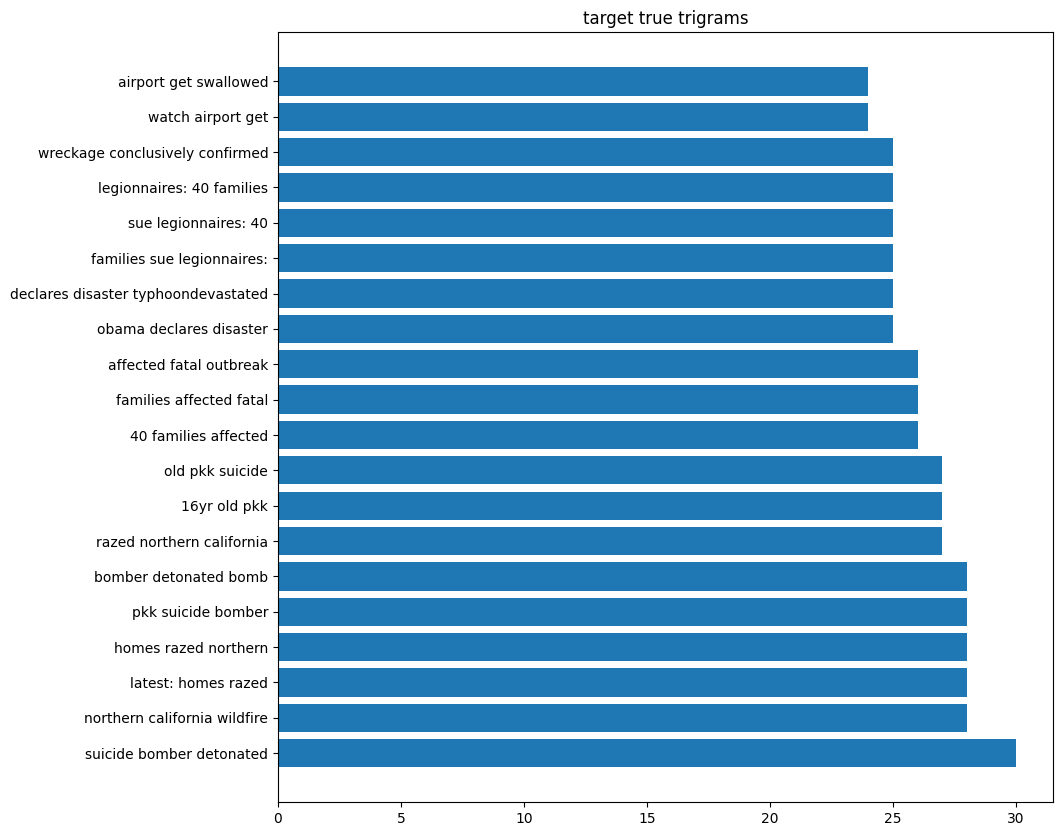

In [95]:
x1 = [i[0] for i in countB]
x1 = [' '.join(i) for i in x1]
y1 = [i[1] for i in countB]

plt.figure(figsize=(10, 10))
plt.barh(x1, y1)
plt.title('target true trigrams')
plt.show()

C:\Users\eduar\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


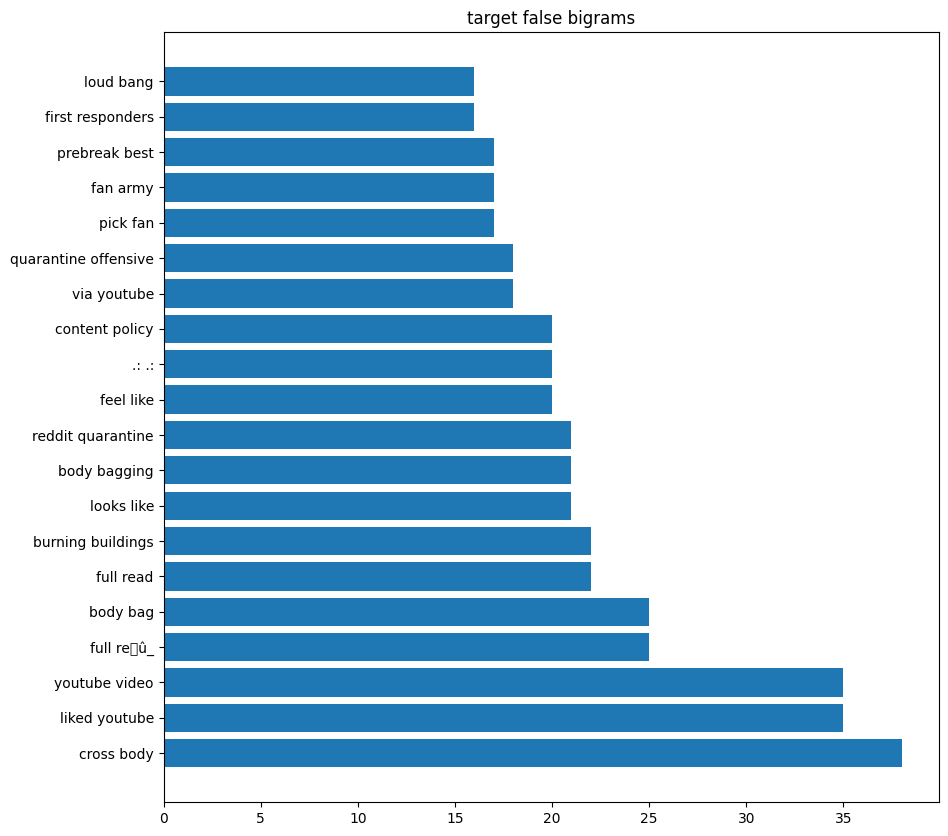

In [96]:
# BIGRAMS FALSE
x2 = [i[0] for i in countC]
x2 = [' '.join(i) for i in x2]
y2 = [i[1] for i in countC]

plt.figure(figsize=(10, 10))
plt.barh(x2, y2)
plt.title('target false bigrams')
plt.show()


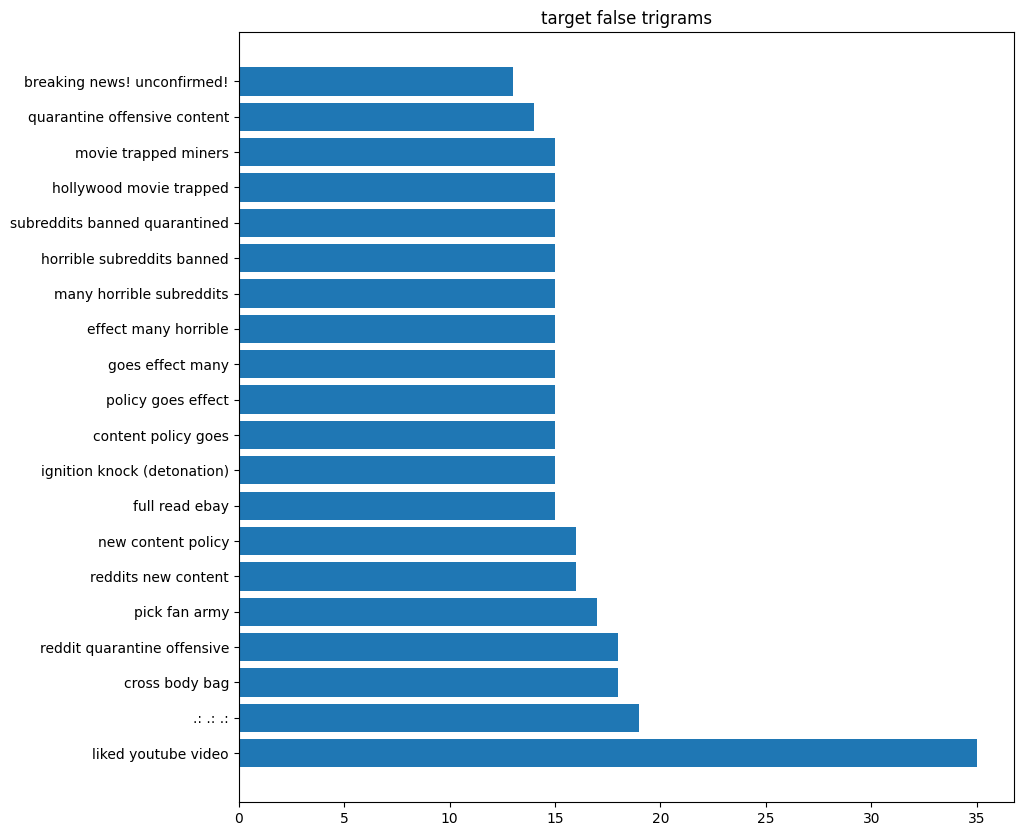

In [97]:
# TRIGRAMS FALSE
x3 = [i[0] for i in countD]
x3 = [' '.join(i) for i in x3]
y3 = [i[1] for i in countD]

plt.figure(figsize=(10, 10))
plt.barh(x3, y3)
plt.title('target false trigrams')
plt.show()

# Analisis exploratorio

In [98]:
# las 5 palabras mas frecuentes en target true son
print("Las 5 palabras mas frecuentes en target true son")
print(targetTrueWords[:5])

Las 5 palabras mas frecuentes en target true son
fire       158
news       118
via        117
suicide    109
...        107
Name: count, dtype: int64


In [99]:
# las 5 palabras mas frecuentes en target true son
print("Las 5 palabras mas frecuentes en target false son")
print(targetFalseWords[:5])

Las 5 palabras mas frecuentes en target false son
like    250
im      242
amp;    190
new     163
get     163
Name: count, dtype: int64


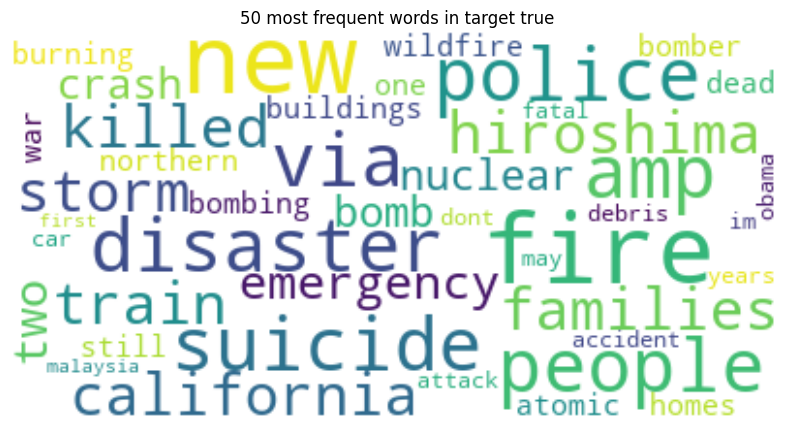

In [100]:
from wordcloud import WordCloud

# 50 most frequent words in target true
text = ' '.join(targetTrueWords.index[:50])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('50 most frequent words in target true')
plt.axis("off")
plt.show()

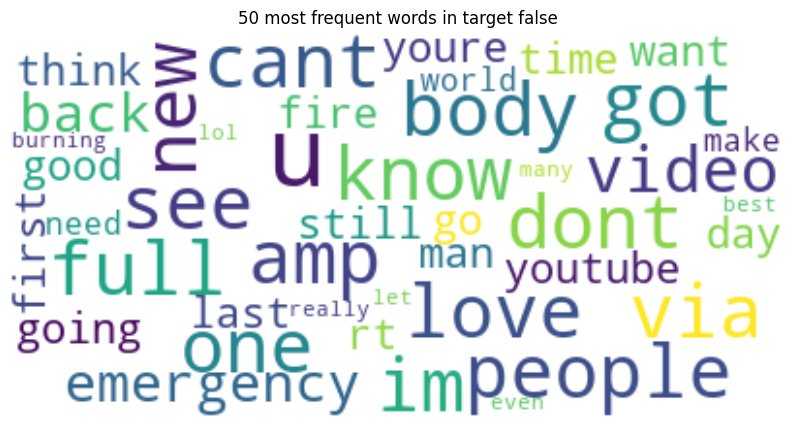

In [101]:
# 50 most frequent words in target false
text = ' '.join(targetFalseWords.index[:50])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('50 most frequent words in target false')
plt.axis("off")
plt.show()

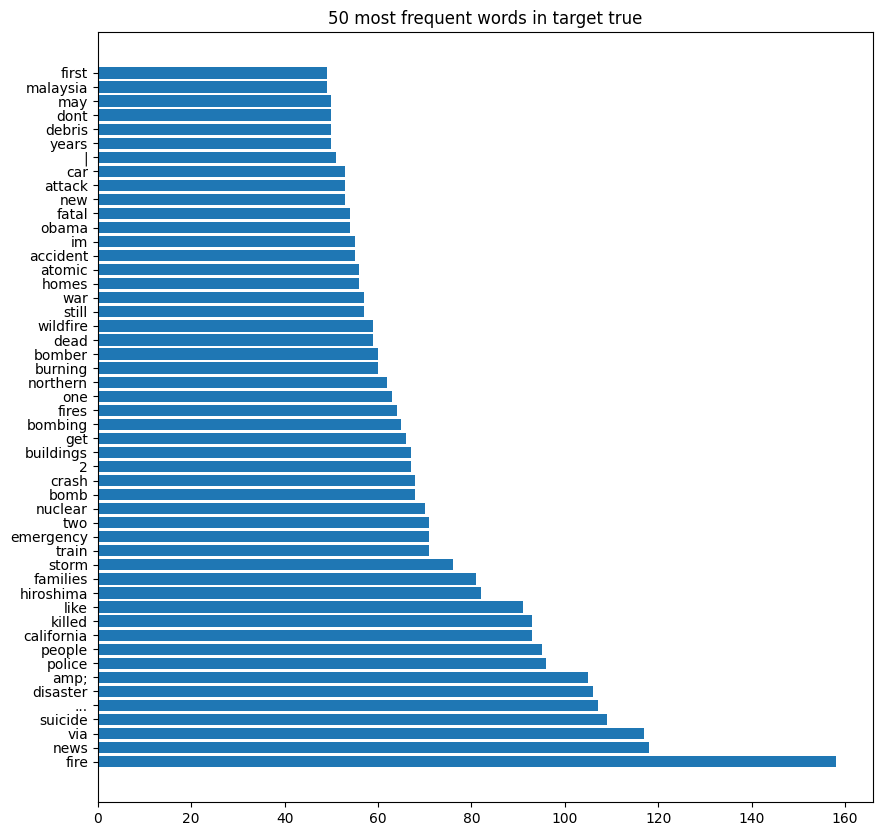

In [102]:
# plot a frequency graph of the 50 most frequent words in target true
plt.figure(figsize=(10, 10))
plt.barh(targetTrueWords.index[:50], targetTrueWords[:50])
plt.title('50 most frequent words in target true')
plt.show()

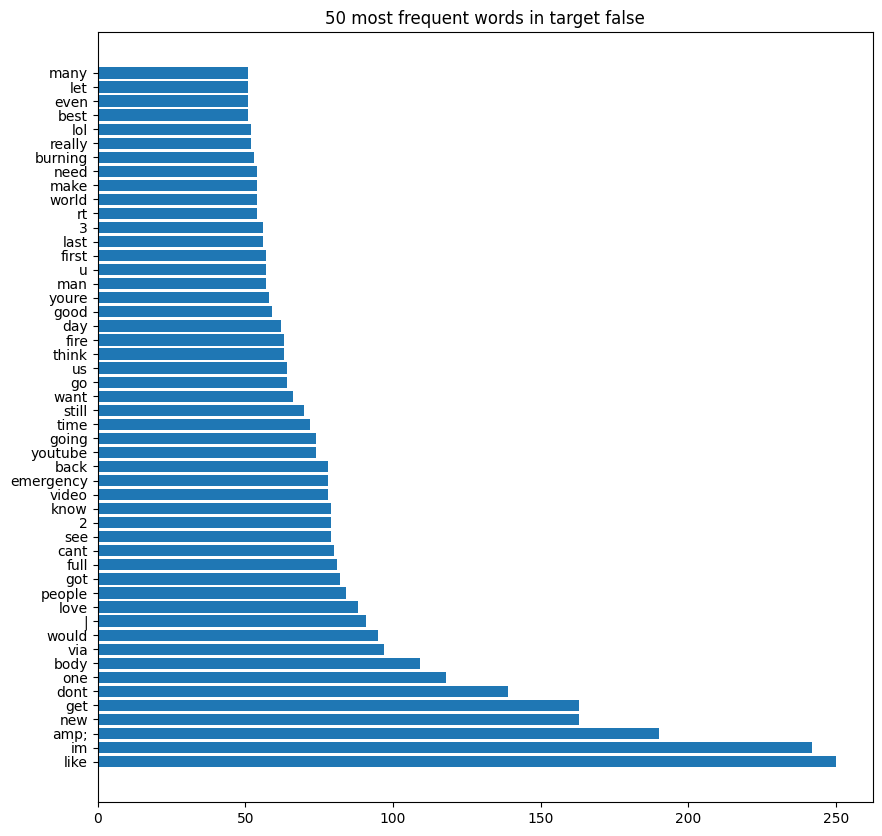

In [103]:
# plot a frequency graph of the 50 most frequent words in target false
plt.figure(figsize=(10, 10))
plt.barh(targetFalseWords.index[:50], targetFalseWords[:50])
plt.title('50 most frequent words in target false')
plt.show()

In [104]:

# Definir el número máximo de palabras a considerar como características
max_features = 10000

# Definir la longitud máxima de las secuencias
maxlen = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data['text_lowercase'])
sequences = tokenizer.texts_to_sequences(train_data['text_lowercase'])

word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(train_data['target'])
print('Shape de los datos del tensor:', data.shape)
print('Shape de la etiqueta del tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2)

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

def classify_tweet(tweet):
    # Tokenizar y pad el tweet
    sequence = tokenizer.texts_to_sequences([tweet])
    data = pad_sequences(sequence, maxlen=maxlen)
    
    # Predecir con el modelo
    prediction = model.predict(data)
    
    if prediction > 0.5:
        return "Desastre"
    else:
        return "No desastre"
    
# Seleccionar los primeros 100 datos
sample_data = train_data.iloc[:100]

# Aplicar la función a la columna de texto
sample_data['classification'] = sample_data['text_lowercase'].apply(classify_tweet)

# Mostrar la tabla
sample_data[['text_lowercase', 'classification']]
# Guardar la tabla en un archivo CSV
sample_data[['text_lowercase', 'classification']].to_excel('classification_results.xlsx', index=False)

Se encontraron 17751 tokens únicos.
Shape de los datos del tensor: (7613, 200)
Shape de la etiqueta del tensor: (7613,)
Epoch 1/100
191/191 [==============================] - 2s 6ms/step - loss: 0.6721 - acc: 0.5837 - val_loss: 0.6372 - val_acc: 0.6316
Epoch 2/100
191/191 [==============================] - 1s 4ms/step - loss: 0.5635 - acc: 0.7535 - val_loss: 0.5123 - val_acc: 0.7781
Epoch 3/100
191/191 [==============================] - 1s 4ms/step - loss: 0.4283 - acc: 0.8266 - val_loss: 0.4587 - val_acc: 0.7978
Epoch 4/100
191/191 [==============================] - 1s 5ms/step - loss: 0.3584 - acc: 0.8589 - val_loss: 0.4523 - val_acc: 0.8043
Epoch 5/100
191/191 [==============================] - 1s 7ms/step - loss: 0.3176 - acc: 0.8724 - val_loss: 0.4598 - val_acc: 0.8030
Epoch 6/100
191/191 [==============================] - 1s 6ms/step - loss: 0.2860 - acc: 0.8885 - val_loss: 0.4704 - val_acc: 0.8076
Epoch 7/100
191/191 [==============================] - 1s 5ms/step - loss: 0.2583 

C:\Users\eduar\AppData\Local\Temp\ipykernel_3104\4129470167.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['classification'] = sample_data['text_lowercase'].apply(classify_tweet)


# Discusión de resultados

Las palabras mencionadas son comúnmente utilizadas en Twitter para informar sobre peligros debido a su alta relevancia en situaciones de emergencia. Estos términos abarcan una variedad de eventos críticos, lo que lleva a los usuarios a compartir información rápidamente y difundirla al público en tiempo real.